# <h2 align="center">Classificação de Imagens áereas</h2>

Data Science.: PhD.Eddy Giusepe Chirinos Isidro

<font color="orange">Neste script vamos a entrenar uma Rede Neural Convolucional para classificação de Imagens Aéreas. Depois de executar este notebook obteremos um arquivo `model.zip` que vamos adjuntar a nossa aplicação `Flask`. No script app.py verás uma nova rota chamada `predict` na qual poderemos enviar imagens e obter as predições de nosso modelo.</font>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install wget

/home/eddygiusepe/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/eddygiusepe/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


# Nosso Dataset

In [3]:
import wget

url = 'https://mymldatasets.s3.eu-de.cloud-object-storage.appdomain.cloud/UCMerced_LandUse.zip'
wget.download(url)


'UCMerced_LandUse (1).zip'

In [4]:
import zipfile
with zipfile.ZipFile('UCMerced_LandUse.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [5]:
import os
from pathlib import Path

PATH = Path('dataset/Images')

labels = os.listdir(PATH)
labels, len(labels)

(['parkinglot',
  'mediumresidential',
  'chaparral',
  'airplane',
  'sparseresidential',
  'storagetanks',
  'buildings',
  'mobilehomepark',
  'river',
  'runway',
  'golfcourse',
  'overpass',
  'harbor',
  'freeway',
  'denseresidential',
  'tenniscourt',
  'agricultural',
  'beach',
  'baseballdiamond',
  'intersection',
  'forest'],
 21)

In [6]:
for label in labels:
    items = os.listdir(PATH/label)
    print(label, ':', len(items))

parkinglot : 100
mediumresidential : 100
chaparral : 100
airplane : 100
sparseresidential : 100
storagetanks : 100
buildings : 100
mobilehomepark : 100
river : 100
runway : 100
golfcourse : 100
overpass : 100
harbor : 100
freeway : 100
denseresidential : 100
tenniscourt : 100
agricultural : 100
beach : 100
baseballdiamond : 100
intersection : 100
forest : 100


<font color="orange">Nosso Dataset está composto por imagens aéreas. Para cada uma temos uma etiqueta. Existem $21$ classes diferentes e temos $100$ amostras para cada etiqueta.</font>

In [7]:
import pandas as pd

img_paths, cls = [], []
for i, label in enumerate(labels):
    names = os.listdir(PATH/label)
    img_paths += [PATH/label/name for name in names]
    cls += [i for name in names]
    
df = pd.DataFrame({'img': img_paths, 'label': cls})
df.sample(5)

,img,label
32,dataset/Images/parkinglot/parkinglot17.tif,0
22,dataset/Images/parkinglot/parkinglot91.tif,0
416,dataset/Images/sparseresidential/sparseresiden...,4
76,dataset/Images/parkinglot/parkinglot20.tif,0
1659,dataset/Images/agricultural/agricultural77.tif,16


In [8]:
len(df)

2100

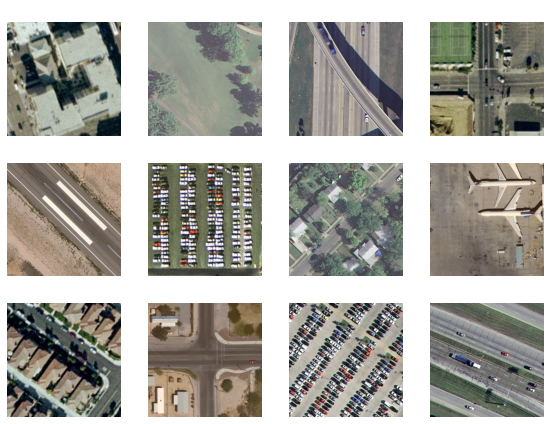

In [9]:
import matplotlib.pyplot as plt
from skimage import io
import random

r, c = 3, 4
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(df)-1)
        img_path, label = df['img'][ix], df['label'][ix]
        img = io.imread(img_path)
        plt.imshow(img)
        plt.title(labels[label], color="white")
        plt.axis("off")
plt.tight_layout()
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(df, test_size=0.2, shuffle=True)
len(train_df), len(val_df)


(1680, 420)

In [13]:
import torch

class Dataset(torch.utils.data.Dataset):
    def __init__(self, imgs, labels, trans):
        self.imgs = imgs 
        self.labels = labels
        self.trans = trans # Aplicamos algumas transformações
    
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, ix):
        img = io.imread(self.imgs[ix]) 
        label = self.labels[ix]
        img = self.trans(image=img)['image'] 
        # Aqui a nos retorna as imagens NORMALIZADAS entere 0 e 1        
        return torch.from_numpy(img / 255.).permute(2,0,1).float(), torch.tensor(label).long()

In [14]:
!pip install albumentations

/home/eddygiusepe/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/eddygiusepe/.local/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [15]:
import albumentations as A

trans = A.Compose([
    A.Resize(224,224),
    A.VerticalFlip(p=0.5)
])

dataset = {
    'train': Dataset(train_df['img'].values, train_df['label'].values, trans),
    'val': Dataset(val_df['img'].values, val_df['label'].values, trans)
}

len(dataset['train']), len(dataset['val'])

(1680, 420)

<font color="orange">Observamos que temos poucos Dados, então vamos a usar `Transfer Learning`.</font>

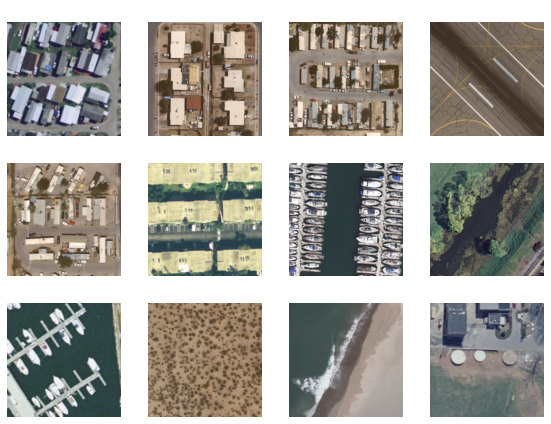

In [23]:
r, c = 3, 4
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset['train'])-1)
        img, label = dataset['train'][ix]
        plt.imshow(img.permute(1,2,0))
        plt.title(labels[label.item()], color="white")
        plt.axis("off")
plt.tight_layout()
plt.show()

In [25]:
# Criamos nosso Dataloader

bs, nw = 32, 4 


dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=bs, shuffle=True, num_workers=nw, pin_memory=True),
    'val': torch.utils.data.DataLoader(dataset['val'], batch_size=bs, shuffle=False, num_workers=nw, pin_memory=True)
}

imgs, labs = next(iter(dataloader['train']))

imgs.shape, imgs.dtype, imgs.max(), imgs.min(), labs.shape

(torch.Size([32, 3, 224, 224]),
 torch.float32,
 tensor(1.),
 tensor(0.),
 torch.Size([32]))

# Nosso Modelo

In [26]:
import torchvision

class Model(torch.nn.Module):
    def __init__(self, labels):
      super().__init__()
      self.labels = labels
      # Observamos que é uma Rede Neural ResNet18 --> ou seja CONVOLUCIONAL
      # A saída original é 1000, mas nós só passaremos 21 (classes)
      self.resnet = torchvision.models.resnet18(pretrained=True)        
      self.resnet.fc = torch.nn.Linear(512, len(self.labels))

    def forward(self, x):
      return self.resnet(x)

In [27]:
model = Model(labels)

outputs = model(torch.randn(32, 3, 224, 224))
outputs.shape

torch.Size([32, 21])

In [31]:
# Aqui podemos ver as camadas:
model

Model(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

# Treinamento

In [36]:
from tqdm import tqdm_notebook as tqdm
import numpy as np


device = "cuda" if torch.cuda.is_available() else "cpu"



def fit(model, dataloader, epochs=8, lr=0.0001):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    model.to(device)
    hist = {'loss': [], 'acc': [], 'test_loss': [], 'test_acc': []}
    best_acc = 0.
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_acc = [], []
      model.train()
      for imgs, labs in bar:
        imgs, labs = imgs.to(device), labs.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, labs)
        loss.backward()
        optimizer.step()
        acc = (torch.argmax(y_hat, axis=1) == labs).sum().item() / len(labs)
        train_loss.append(loss.item())
        train_acc.append(acc)
        bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['acc'].append(np.mean(train_acc))
      bar = tqdm(dataloader['val'])
      test_loss, test_acc = [], []
      
      model.eval()
      
      with torch.no_grad():
        for imgs, labs in bar:
          imgs, labs = imgs.to(device), labs.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, labs)
          acc = (torch.argmax(y_hat, axis=1) == labs).sum().item() / len(labs)
          test_loss.append(loss.item())
          test_acc.append(acc)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_acc {np.mean(test_acc):.5f}")
      if np.mean(test_acc) > best_acc:
        best_acc = np.mean(test_acc) 
        torch.save(model.state_dict(), 'model.pth')
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_acc'].append(np.mean(test_acc))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f} test_loss {np.mean(test_loss):.5f} test_acc {np.mean(test_acc):.5f}")
    
    return hist

In [37]:
model = Model(labels)

hist = fit(model, dataloader)

  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]


Epoch 1/8 loss 1.12585 acc 0.73939 test_loss 0.30909 test_acc 0.93304


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]


Epoch 2/8 loss 0.17841 acc 0.97229 test_loss 0.16630 test_acc 0.95536


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]


Epoch 3/8 loss 0.08888 acc 0.98880 test_loss 0.12705 test_acc 0.96875


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]


Epoch 4/8 loss 0.05320 acc 0.99528 test_loss 0.10241 test_acc 0.96652


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]


Epoch 5/8 loss 0.03715 acc 0.99646 test_loss 0.13059 test_acc 0.97098


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]


Epoch 6/8 loss 0.03364 acc 0.99587 test_loss 0.12341 test_acc 0.96429


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]


Epoch 7/8 loss 0.01689 acc 0.99941 test_loss 0.08555 test_acc 0.97545


  0%|          | 0/53 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]


Epoch 8/8 loss 0.01162 acc 0.99941 test_loss 0.08141 test_acc 0.97098


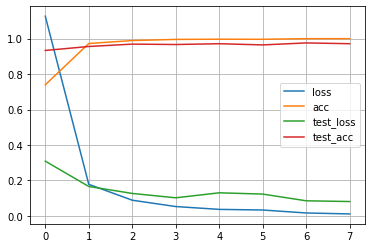

In [42]:
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

# Avaliação

In [43]:
model.load_state_dict(torch.load('model.pth'))
model.to(device)
model.eval()
with torch.no_grad():
  bar = tqdm(dataloader['val'])
  test_acc = []
  for imgs, labs in bar:
    imgs, labs = imgs.to(device), labs.to(device)
    y_hat = model(imgs)
    acc = (torch.argmax(y_hat, axis=1) == labs).sum().item() / len(labs)
    test_acc.append(acc)
  print(f'acc {np.mean(test_acc):.5f}')

  0%|          | 0/14 [00:00<?, ?it/s]

acc 0.97321


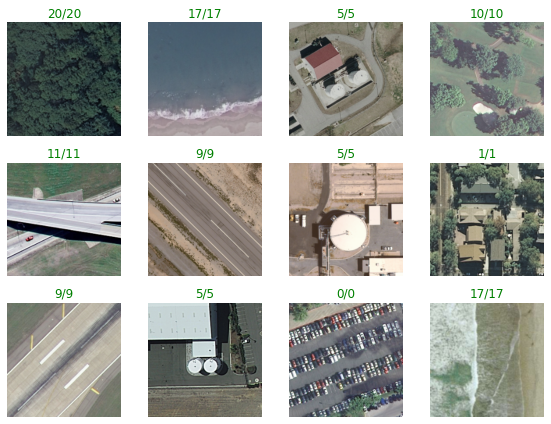

In [44]:
r, c = 3, 4
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ax = plt.subplot(r, c, _r*c + _c + 1)
        ix = random.randint(0, len(dataset['val'])-1)
        img, label = dataset['val'][ix]
        y_hat = model(img.unsqueeze(0).to(device))
        lab = torch.argmax(y_hat, axis=1)[0].item()
        plt.imshow(img.permute(1,2,0))
        plt.title(f'{label}/{lab}', color="red" if label != lab else "green")
        plt.axis("off")
plt.tight_layout()
plt.show()

# Exportar nosso Modelo

In [45]:
torch.jit.save(torch.jit.script(model.cpu()), 'model.zip')

In [46]:
# Carregamos nosso Modelo para testar ele (similarmente faremos isso no Flask):

model = torch.jit.load('model.zip')

In [47]:
model.to(device)
model.eval()
with torch.no_grad():
  bar = tqdm(dataloader['val'])
  test_acc = []
  for imgs, labs in bar:
    imgs, labs = imgs.to(device), labs.to(device)
    y_hat = model(imgs)
    acc = (torch.argmax(y_hat, axis=1) == labs).sum().item() / len(labs)
    test_acc.append(acc)
  print(f'acc {np.mean(test_acc):.5f}')

  0%|          | 0/14 [00:00<?, ?it/s]

acc 0.97545
